# Outliers
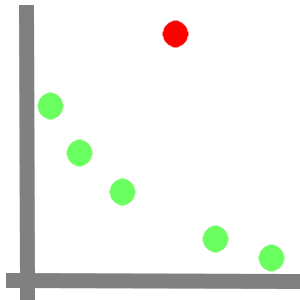

# Setup

In [30]:
import time

import pandas as pd
import numpy as np
import statistics 

from numpy.random import randn

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Univariate

## Sample Dataset

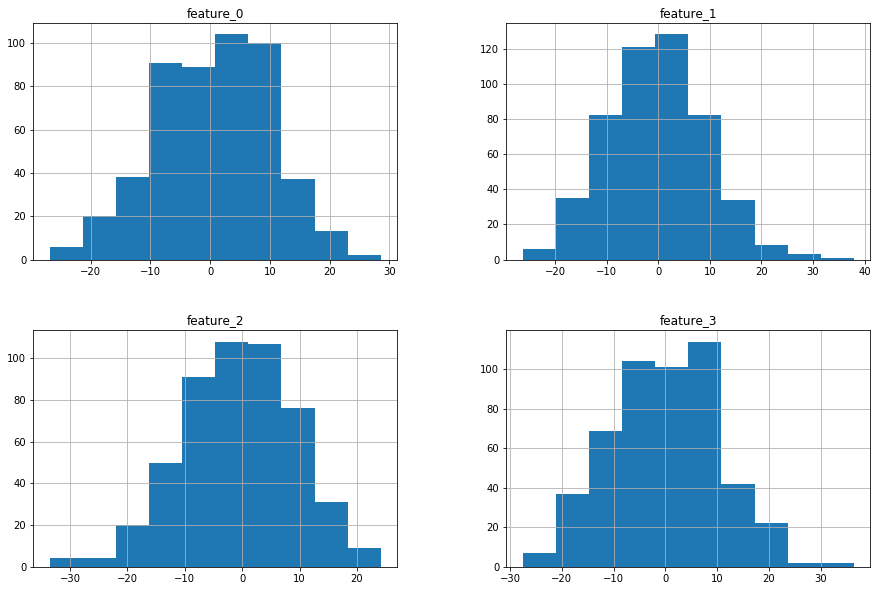

In [31]:
np.random.seed(1337)
dataDF = pd.DataFrame(np.random.normal(scale=10.0, size=(500, 4)),
                      columns=['feature_{}'.format(i) for i in range(4)])
dataDF.hist(figsize=(15,10));

## Standard Deviations
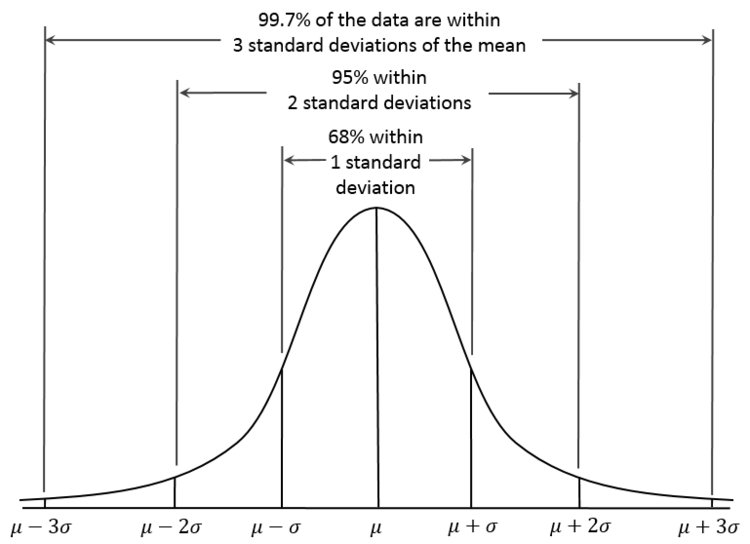

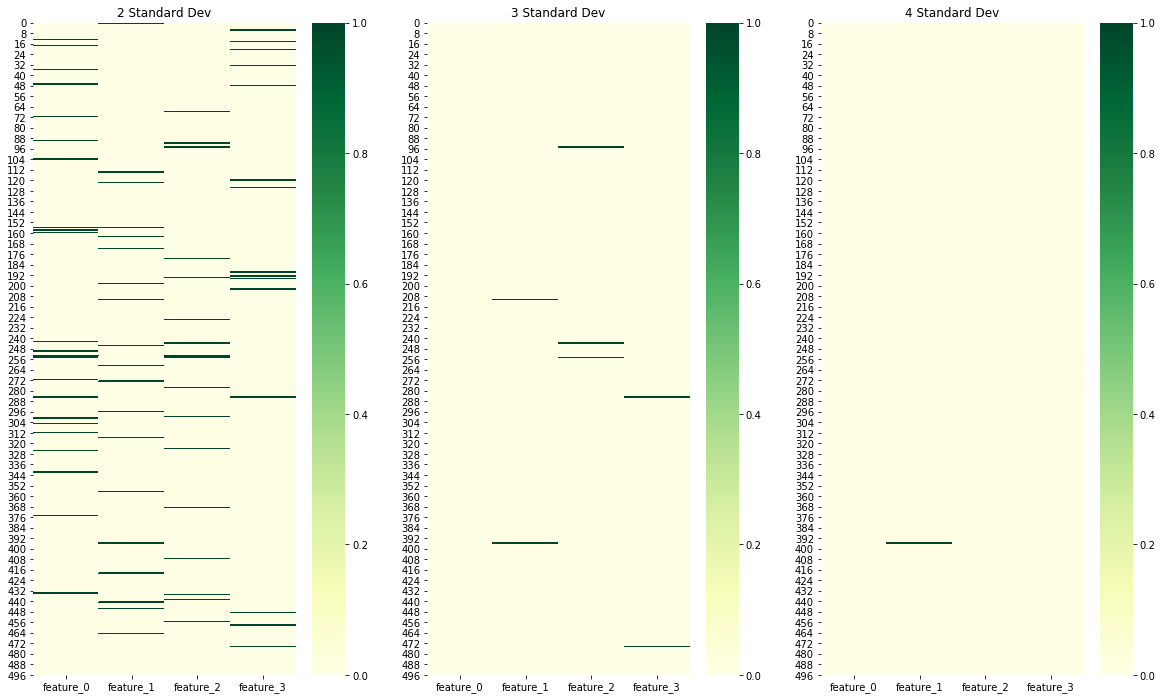

In [32]:
def stdevOutlier(data, threshold):
    low, up = data.mean() - (threshold * data.std()), data.mean() + (threshold * data.std())  
    return [True if x < low or x > up else False for x in data]

stdev2 = dataDF.apply(stdevOutlier, threshold=2.0)
stdev3 = dataDF.apply(stdevOutlier, threshold=3.0)
stdev4 = dataDF.apply(stdevOutlier, threshold=4.0)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 12));
ax1.set_title('2 Standard Dev');
ax2.set_title('3 Standard Dev');
ax3.set_title('4 Standard Dev');

sns.heatmap(stdev2, cmap='YlGn', ax=ax1);
sns.heatmap(stdev3, cmap='YlGn', ax=ax2);
sns.heatmap(stdev4, cmap='YlGn', ax=ax3);

plt.show()

## Interquartile Range
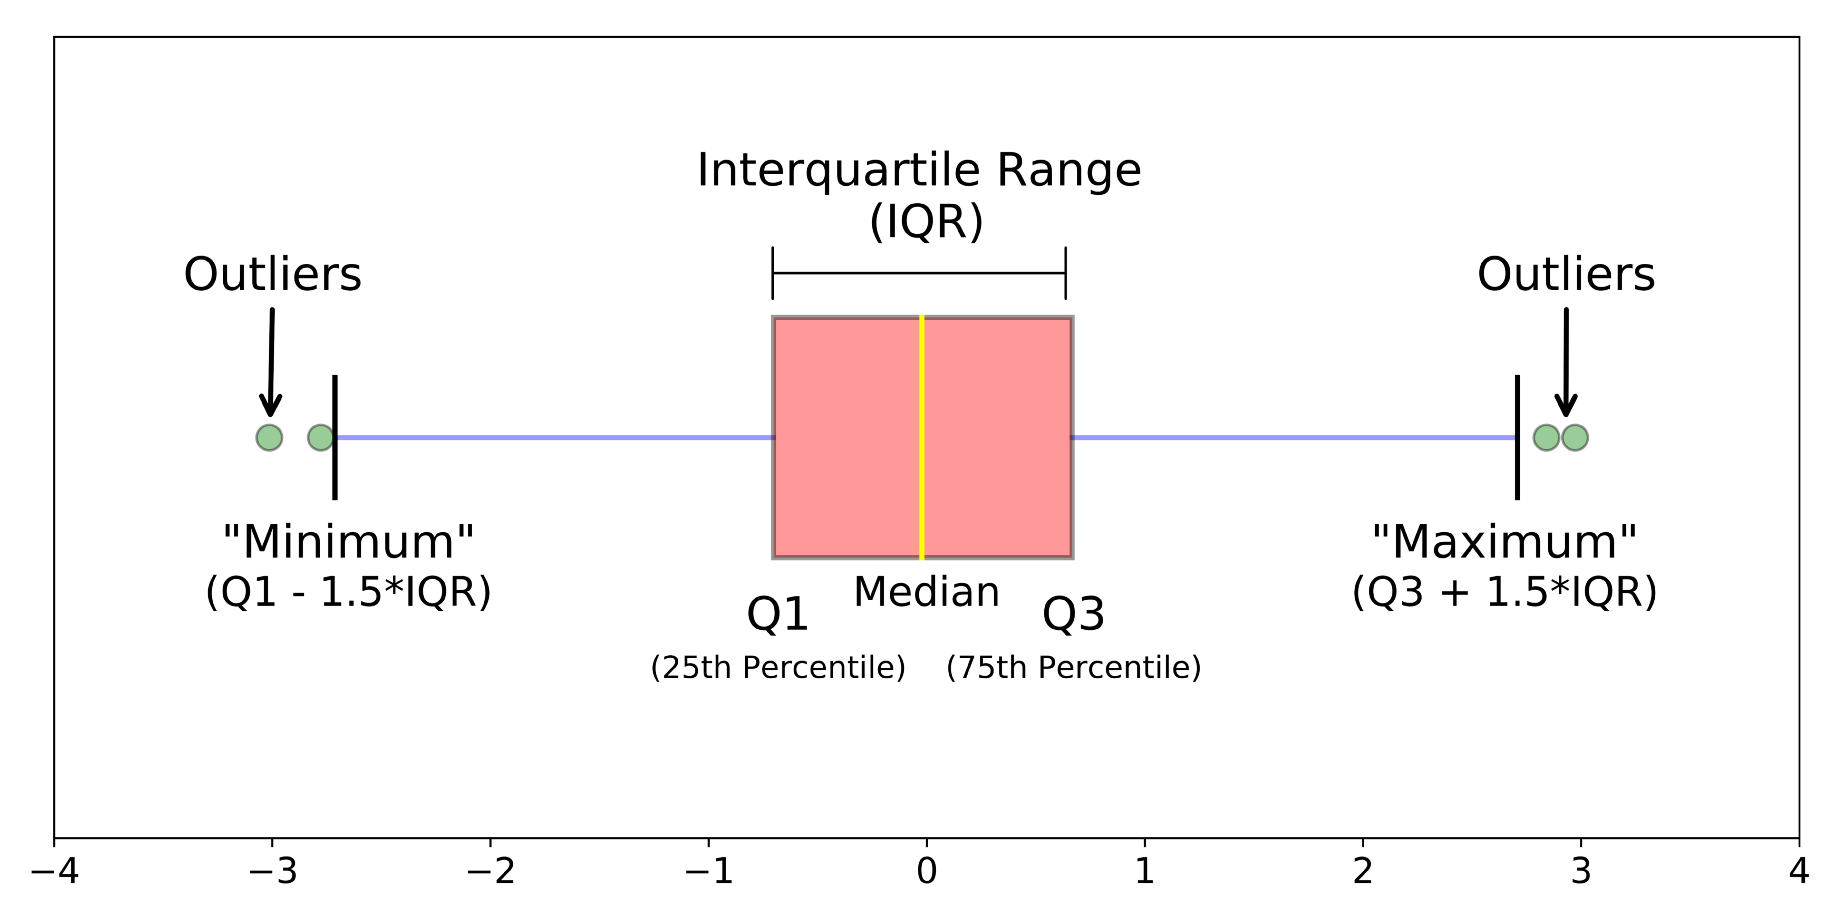

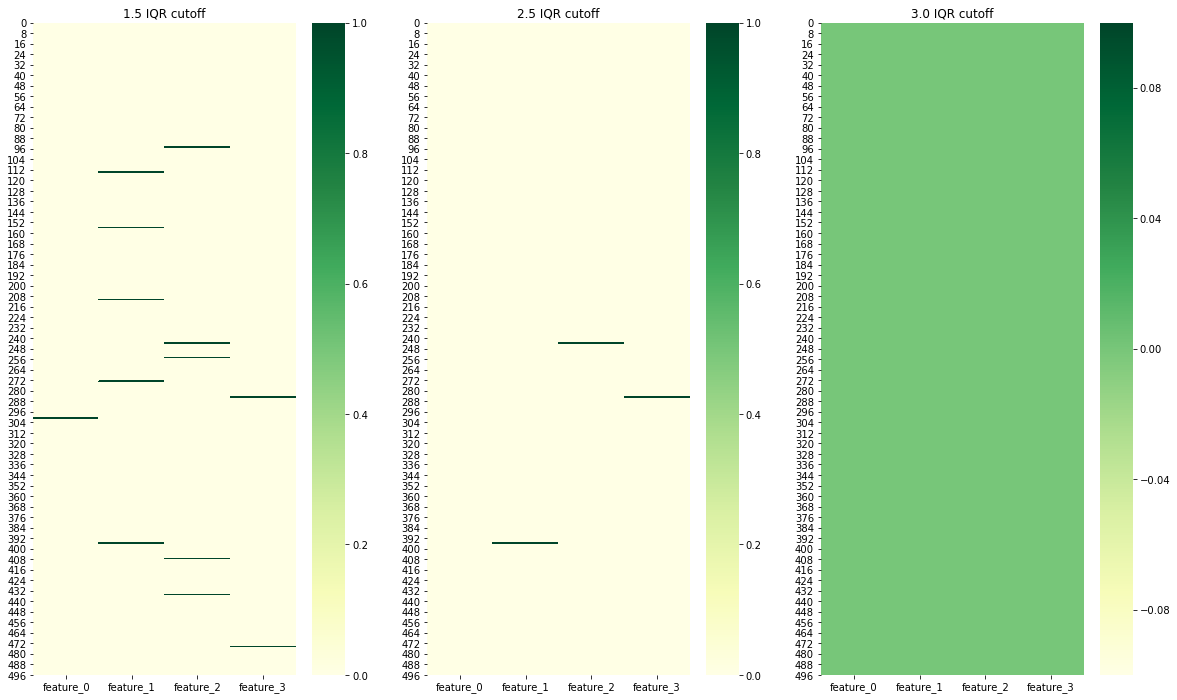

In [33]:
def iqrOutlier(data, threshold):
    cutoff = (np.percentile(data, 75) - np.percentile(data, 25)) * threshold
    lower, upper = np.percentile(data, 25) - cutoff, np.percentile(data, 75) + cutoff
    return [True if x < lower or x > upper else False for x in data]
    
# For comparison, make one array each at varying values of k.
iqr1 = dataDF.apply(iqrOutlier, threshold=1.5)
iqr2 = dataDF.apply(iqrOutlier, threshold=2.0)
iqr3 = dataDF.apply(iqrOutlier, threshold=3.0)
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 12));
ax1.set_title('1.5 IQR cutoff');
ax2.set_title('2.5 IQR cutoff');
ax3.set_title('3.0 IQR cutoff');

sns.heatmap(iqr1, cmap='YlGn', ax=ax1);
sns.heatmap(iqr2, cmap='YlGn', ax=ax2);
sns.heatmap(iqr3, cmap='YlGn', ax=ax3);

# Bivariate Dataset

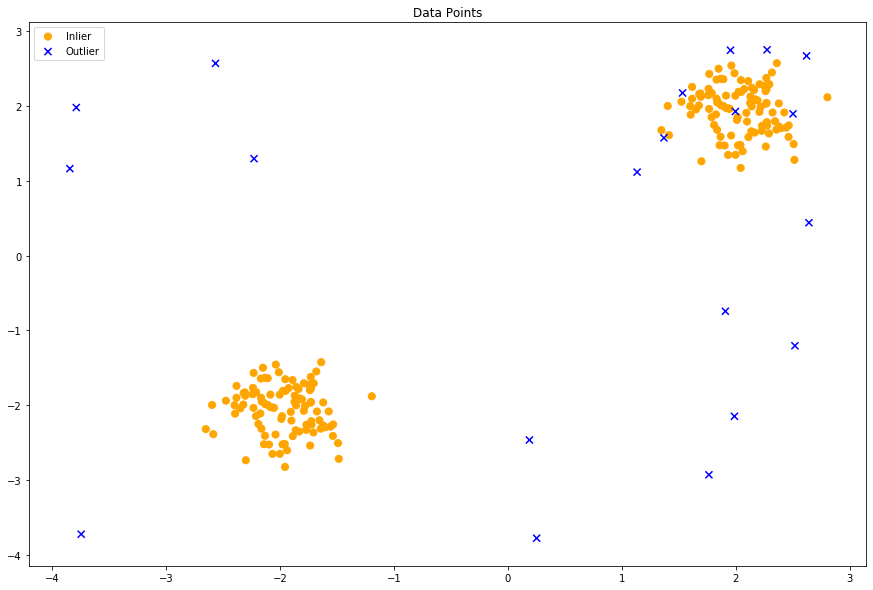

In [34]:
np.random.seed(1337)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

# Range for plotting decision boundaries
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

# Setup Truth
n_outliers = len(X_outliers)
truth = np.ones(len(X), dtype=int)
truth[-n_outliers:] = -1
col = np.where(truth == 1, 'orange', 'blue')

#Plot
plt.figure(figsize=(15,10))
plt.title("Data Points")
plt.scatter(X[truth==1][:, 0], X[truth==1][:, 1], color=col[truth==1], s=50., marker='o', label='Inlier')
plt.scatter(X[truth==-1][:, 0], X[truth==-1][:, 1], color=col[truth==-1], s=50., marker='x', label='Outlier')
legend = plt.legend(loc='upper left')

## Tracking

In [35]:
df = pd.DataFrame(columns=['Outlier Precision', 'Outlier Recall', 'Inlier Precision', 'Inlier Recall', 'F1 Score'])

## Helper Functions

In [36]:
def confusion(technique, df, yHat, y):
    confusionMatrix = confusion_matrix(y, yHat)
    classReport = classification_report(y, yHat)
    outPrecision = confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0])
    outRecall    = confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1])
    inPrecision  = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[0][1])
    inRecall     = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[1][0])
    f1 = f1_score(y, yHat)
    df.loc[technique] = [outPrecision, outRecall, inPrecision, inRecall, f1]
    print(technique)
    print(confusionMatrix)
    print(classReport)
    return confusionMatrix, classReport, (outPrecision, outRecall), (inPrecision, inRecall)

## Univariate - Parametric
In the univariate case, we'll look at +- 3 standard deviations in both dimensions calling an outlier a data point that falls outside the range.

In [37]:
mean0 = statistics.mean(X[:,0])
sd0   = statistics.stdev(X[:,0])
low0  = mean0 - 3 * sd0
high0 = mean0 + 3 * sd0

mean1 = statistics.mean(X[:,1])
sd1   = statistics.stdev(X[:,1])
low1  = mean1 - 3 * sd1
high1 = mean1 + 3 * sd1

print('X0 : Mean {:.2f}, Stdev {:.2f}, Low {:.2f}, High {:.2f}'.format(mean0, sd0, low0, high0))
print('X1 : Mean {:.2f}, Stdev {:.2f}, Low {:.2f}, High {:.2f}'.format(mean1, sd1, low1, high1))

X0 : Mean 0.08, Stdev 2.05, Low -6.09, High 6.24
X1 : Mean -0.02, Stdev 2.05, Low -6.17, High 6.14


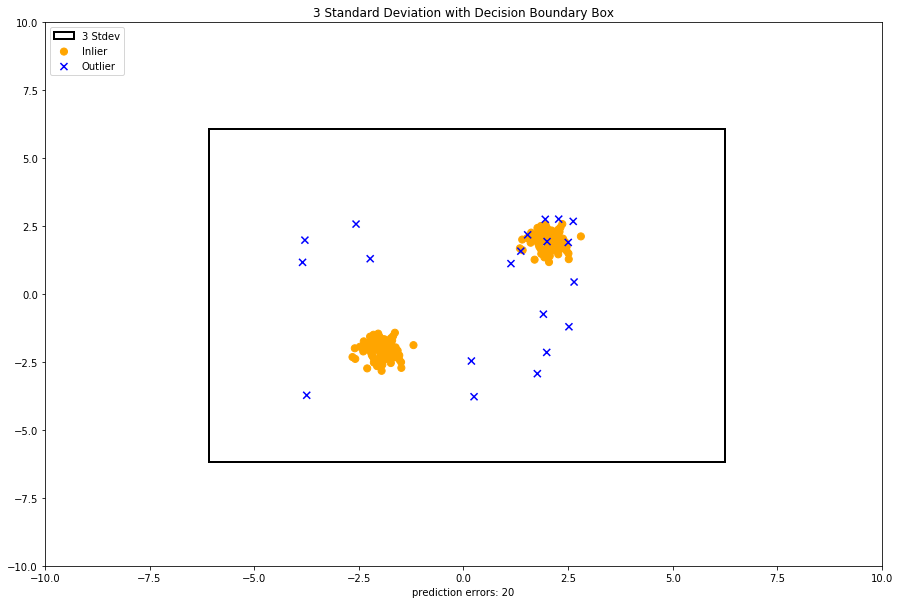

In [38]:
np.random.seed(1337)

# Set flag
y_pred = np.where((X[:, 0] < low0) | (X[:, 0] > high0) | (X[:, 1] < low1) | (X[:, 1] > high1), -1, 1)               

# Errors & Colors
n_errors = (y_pred != truth).sum()
col = np.where(y_pred == truth, 'orange', 'blue')

#Plot Points
plt.figure(figsize=(15,10))
plt.title("3 Standard Deviation with Decision Boundary Box")
ax = plt.scatter(X[truth==1][:, 0], X[truth==1][:, 1], color=col[truth==1], s=50., marker='o', label='Inlier')
plt.scatter(X[truth==-1][:, 0], X[truth==-1][:, 1], color=col[truth==-1], s=50., marker='x', label='Outlier')
plt.xlabel("prediction errors: %d" % (n_errors))

#Add in Decison Boundary
ax = plt.gca()
rect = patches.Rectangle((low0, low1), (high0 - low0), (high1 - low0), 
                         linewidth=2, edgecolor='black', facecolor='none', label='3 Stdev')
ax.add_patch(rect)

#Label Axis 
plt.axis('tight')
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
plt.show()

In [39]:
results = confusion('Univariate - 3 Deviations', df, y_pred, truth)

Univariate - 3 Deviations
[[  0  20]
 [  0 200]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.91      1.00      0.95       200

    accuracy                           0.91       220
   macro avg       0.45      0.50      0.48       220
weighted avg       0.83      0.91      0.87       220



/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [40]:
df

,Outlier Precision,Outlier Recall,Inlier Precision,Inlier Recall,F1 Score
Univariate - 3 Deviations,NaN,0.0,0.909091,1.0,0.952381


## Robust Covariance
The class EllipticEnvelope takes your data X (without labels), and fits a multivariate Gaussian.  This model captures correlations between your data's features, allowing it to distort the Gaussian along the identiy axis taking an elliptical shape. Outliers in X can cause distortion (see the image below) in the fitted Gaussian.  A more robust estimate can be had by using the contamination parameter.  The EllipicalEnvelope algorithm can then discard up to the contamination fraction of data points and generate an ellipsoid with the smallest volumne.
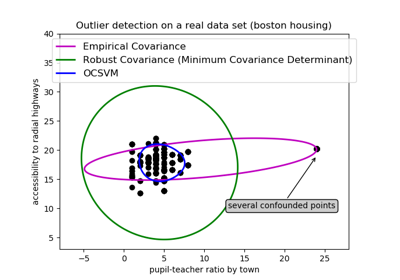

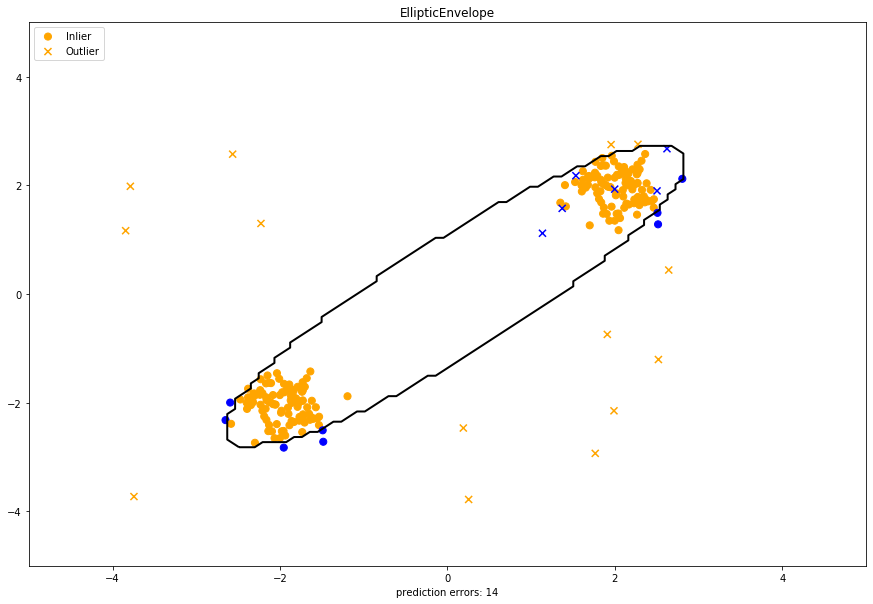

In [41]:
np.random.seed(1337)

# fit the model for outlier detection (default)
clf = EllipticEnvelope(contamination=0.1)

y_pred = clf.fit(X).predict(X)
n_errors = (y_pred != truth).sum()

#Plot Points
plt.figure(figsize=(15,10))
plt.title("EllipticEnvelope")
col = np.where(y_pred == truth, 'orange', 'blue')
plt.scatter(X[truth==1][:, 0], X[truth==1][:, 1], color=col[truth==1], s=50., marker='o', label='Inlier')
plt.scatter(X[truth==-1][:, 0], X[truth==-1][:, 1], color=col[truth==-1], s=50., marker='x', label='Outlier')
plt.xlabel("prediction errors: %d" % (n_errors))

#Plot Decision Boundary
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

#Label Axis 
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
plt.show()

In [42]:
results = confusion('Robust Covariance', df, y_pred, truth)

Robust Covariance
[[ 14   6]
 [  8 192]]
              precision    recall  f1-score   support

          -1       0.64      0.70      0.67        20
           1       0.97      0.96      0.96       200

    accuracy                           0.94       220
   macro avg       0.80      0.83      0.82       220
weighted avg       0.94      0.94      0.94       220



In [43]:
df

,Outlier Precision,Outlier Recall,Inlier Precision,Inlier Recall,F1 Score
Univariate - 3 Deviations,NaN,0.0,0.909091,1.00,0.952381
Robust Covariance,0.636364,0.7,0.969697,0.96,0.964824


## One Class SVM
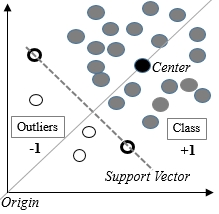

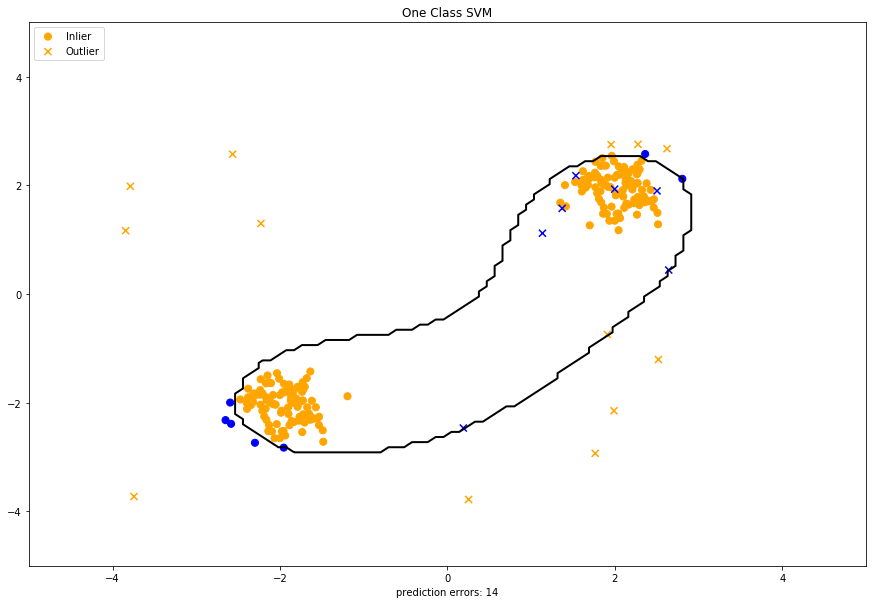

In [44]:
np.random.seed(1337)

# fit the model for outlier detection (default)
clf = svm.OneClassSVM(nu=0.1, 
                      kernel="rbf",
                      gamma=0.1)

y_pred = clf.fit(X).predict(X)
n_errors = (y_pred != truth).sum()

#Plot Points
plt.figure(figsize=(15,10))
plt.title("One Class SVM")
col = np.where(y_pred == truth, 'orange', 'blue')
plt.scatter(X[truth==1][:, 0], X[truth==1][:, 1], color=col[truth==1], s=50., marker='o', label='Inlier')
plt.scatter(X[truth==-1][:, 0], X[truth==-1][:, 1], color=col[truth==-1], s=50., marker='x', label='Outlier')
plt.xlabel("prediction errors: %d" % (n_errors))

#Plot Decision Boundary
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

#Label Axis 
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
plt.show()

In [45]:
results = confusion('One Class SVM', df, y_pred, truth)

One Class SVM
[[ 13   7]
 [  7 193]]
              precision    recall  f1-score   support

          -1       0.65      0.65      0.65        20
           1       0.96      0.96      0.96       200

    accuracy                           0.94       220
   macro avg       0.81      0.81      0.81       220
weighted avg       0.94      0.94      0.94       220



In [46]:
df

,Outlier Precision,Outlier Recall,Inlier Precision,Inlier Recall,F1 Score
Univariate - 3 Deviations,NaN,0.00,0.909091,1.000,0.952381
Robust Covariance,0.636364,0.70,0.969697,0.960,0.964824
One Class SVM,0.650000,0.65,0.965000,0.965,0.965000


## Local Outlier Factor
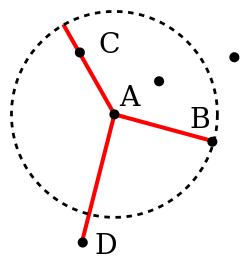

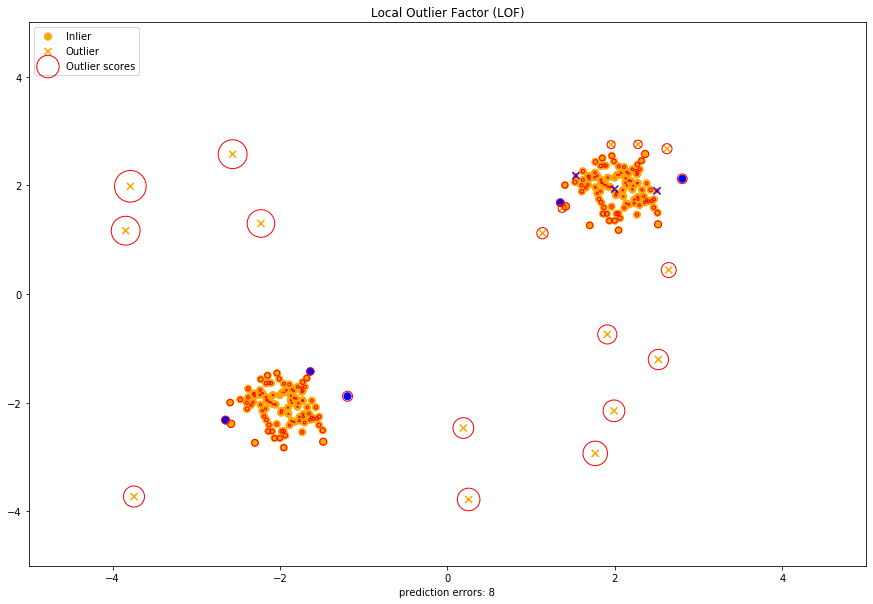

In [47]:
np.random.seed(1337)

#Fit and score model
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != truth).sum()
X_scores = clf.negative_outlier_factor_

#Generate radius & colors
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
col = np.where(y_pred == truth, 'orange', 'blue')

#Plot
plt.figure(figsize=(15,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[truth==1][:, 0], X[truth==1][:, 1], color=col[truth==1], s=50., marker='o', label='Inlier')
plt.scatter(X[truth==-1][:, 0], X[truth==-1][:, 1], color=col[truth==-1], s=50., marker='x', label='Outlier')
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')
plt.xlabel("prediction errors: %d" % (n_errors))

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
plt.show()

In [48]:
results = confusion('Local Outlier Factor', df, y_pred, truth)

Local Outlier Factor
[[ 17   3]
 [  5 195]]
              precision    recall  f1-score   support

          -1       0.77      0.85      0.81        20
           1       0.98      0.97      0.98       200

    accuracy                           0.96       220
   macro avg       0.88      0.91      0.89       220
weighted avg       0.97      0.96      0.96       220



In [49]:
df

,Outlier Precision,Outlier Recall,Inlier Precision,Inlier Recall,F1 Score
Univariate - 3 Deviations,NaN,0.00,0.909091,1.000,0.952381
Robust Covariance,0.636364,0.70,0.969697,0.960,0.964824
One Class SVM,0.650000,0.65,0.965000,0.965,0.965000
Local Outlier Factor,0.772727,0.85,0.984848,0.975,0.979899


## Isolation Forest
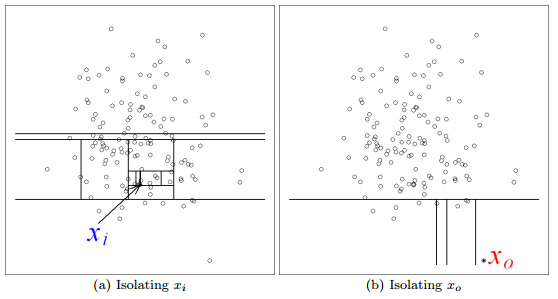

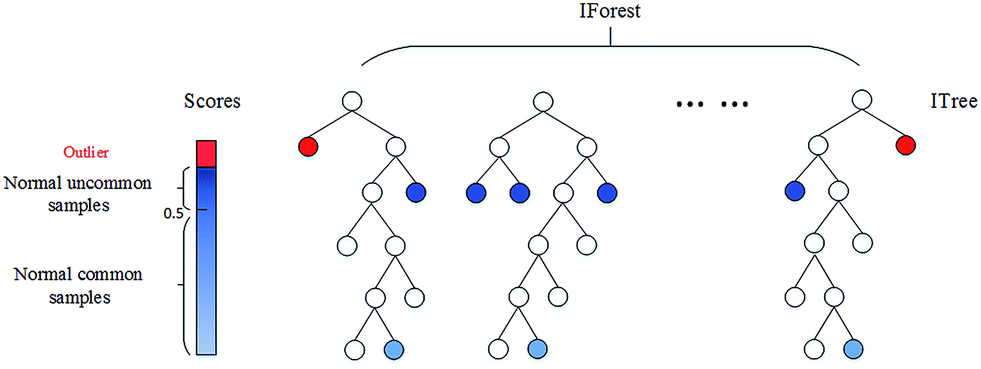

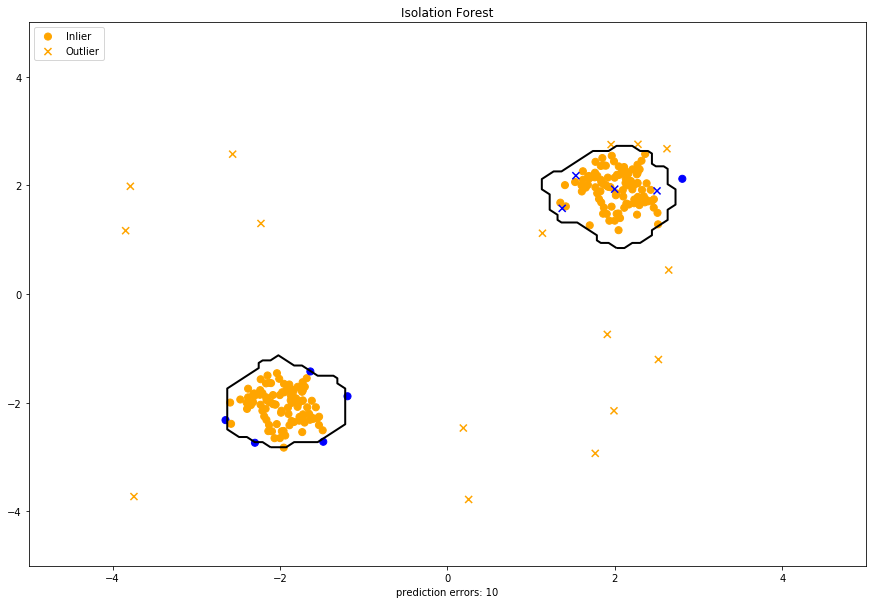

In [50]:
np.random.seed(1337)

#Fit the model 
clf = IsolationForest(behaviour='new', 
                      contamination=.1,
                      random_state=1337)
y_pred = clf.fit(X).predict(X)
n_errors = (y_pred != truth).sum()

#Generate Colors
col = np.where(y_pred == truth, 'orange', 'blue')

#Plot Points
plt.figure(figsize=(15,10))
plt.title("Isolation Forest")
plt.scatter(X[truth==1][:, 0], X[truth==1][:, 1], color=col[truth==1], s=50., marker='o', label='Inlier')
plt.scatter(X[truth==-1][:, 0], X[truth==-1][:, 1], color=col[truth==-1], s=50., marker='x', label='Outlier')
plt.xlabel("prediction errors: %d" % (n_errors))

#Plot Decision Boundary
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

#Label Axis 
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
plt.show()

In [51]:
results = confusion('Isolation Forest', df, y_pred, truth)

Isolation Forest
[[ 16   4]
 [  6 194]]
              precision    recall  f1-score   support

          -1       0.73      0.80      0.76        20
           1       0.98      0.97      0.97       200

    accuracy                           0.95       220
   macro avg       0.85      0.89      0.87       220
weighted avg       0.96      0.95      0.96       220



In [52]:
df

,Outlier Precision,Outlier Recall,Inlier Precision,Inlier Recall,F1 Score
Univariate - 3 Deviations,NaN,0.00,0.909091,1.000,0.952381
Robust Covariance,0.636364,0.70,0.969697,0.960,0.964824
One Class SVM,0.650000,0.65,0.965000,0.965,0.965000
Local Outlier Factor,0.772727,0.85,0.984848,0.975,0.979899
Isolation Forest,0.727273,0.80,0.979798,0.970,0.974874


## Results

In [53]:
df

,Outlier Precision,Outlier Recall,Inlier Precision,Inlier Recall,F1 Score
Univariate - 3 Deviations,NaN,0.00,0.909091,1.000,0.952381
Robust Covariance,0.636364,0.70,0.969697,0.960,0.964824
One Class SVM,0.650000,0.65,0.965000,0.965,0.965000
Local Outlier Factor,0.772727,0.85,0.984848,0.975,0.979899
Isolation Forest,0.727273,0.80,0.979798,0.970,0.974874


# Conclusions
* Our best outlier technique was Local Outlier Factor which edged out Isolation Forests
 * Be cautious of univariate outlier techniques in multi-dimensional data
 * Visualizing outliers is great for story telling (consider PCA or t-SNE to help view higher dimensional datasets)
* Elliplical Envelope
 * Needs data to be in -1 and +1 labels rather than 0, 1
 * Use only on larger data needs n^2/2 data points
 * Consider using CV to find / test for the level of contamination
* Local outlier factor 
 * Relies on KNN can be computationally expensive
 * Consider CV for number of neighbors
 * Does not yield decison boundaries
* Isolation Forests 
 * Have memory constraints on large datasets (don't scale)
 * Good for high dimension datasets
 * Consider using CV to find the optimal number of estimators 
* While this notebook focused on approaches in sklearn, pyOD has an extensive suite

# Other Datasets
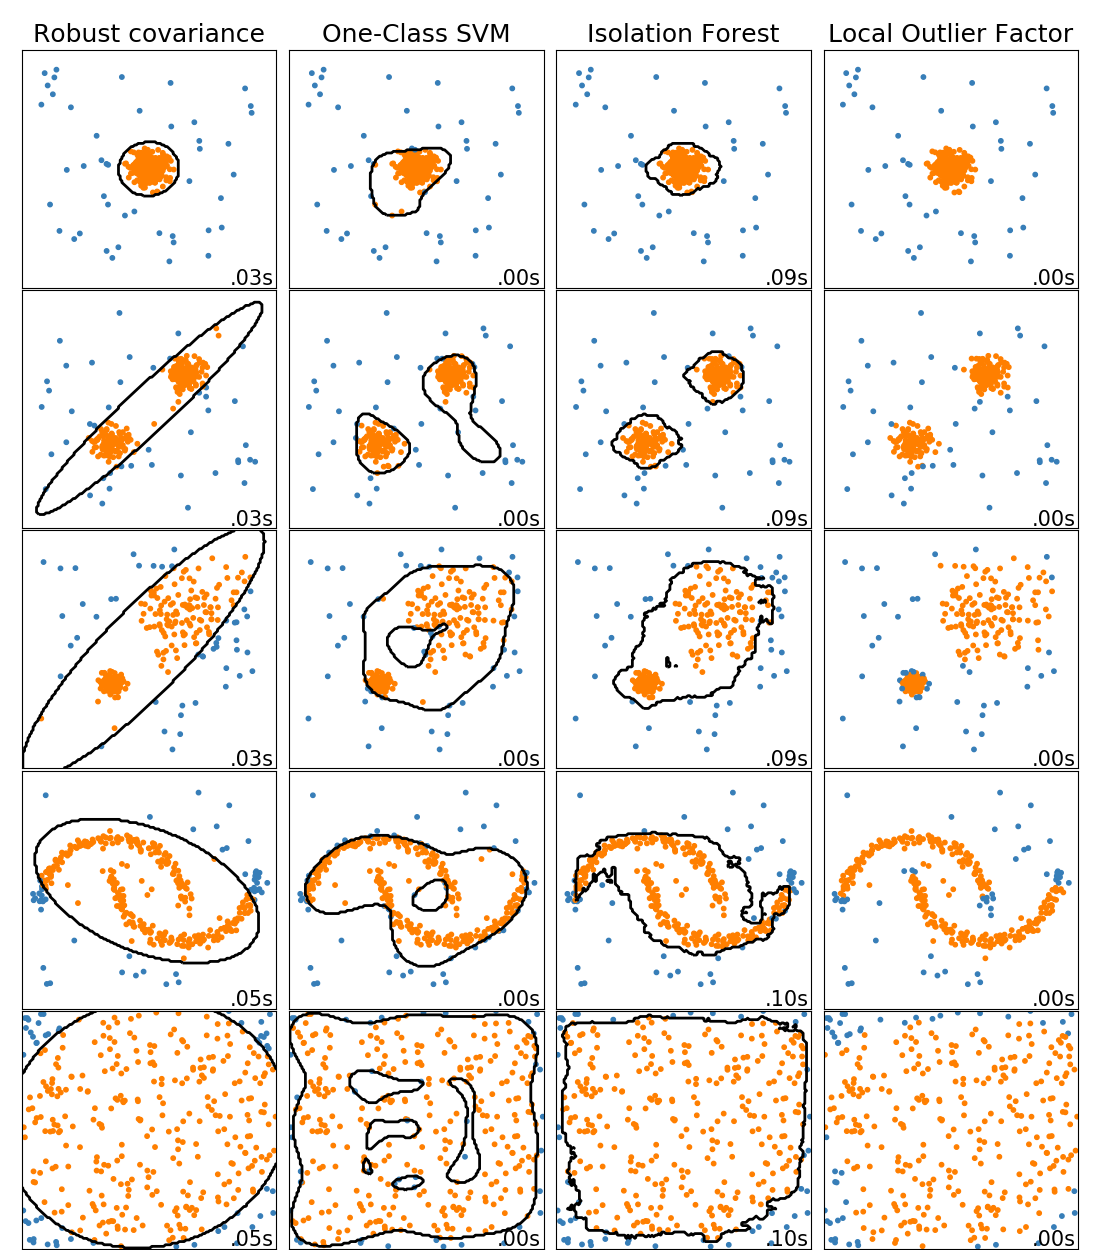
https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py